In [ ]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import auc, precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, precision_recall_curve

In [ ]:
def load_data(dataset_index):
    print(f"Processing dataset {dataset_index}...")
    
    base_path = 'tc-hard/dataset/new_split/pep+cdr3b'
    embed_base_path = 'vibtcr/data/embedNA/val' 
    
    df_train = pd.read_csv(f'{base_path}/train/only-neg-assays/train-{dataset_index}.csv', low_memory=False)
    df_val = pd.read_csv(f'{base_path}/validation/only-neg-assays/validation-{dataset_index}.csv', low_memory=False)
    df_test = pd.read_csv(f'{base_path}/test/only-neg-assays/test-{dataset_index}.csv', low_memory=False)
    train_pep_mol = np.load(f'{embed_base_path}/train{dataset_index}_pep_mol.npy')
    val_pep_mol = np.load(f'{embed_base_path}/val{dataset_index}_pep_mol.npy')
    test_pep_mol = np.load(f'{embed_base_path}/test{dataset_index}_pep_mol.npy')
    train_cdr3 = np.load(f'{embed_base_path}/train{dataset_index}_CDR3_esm.npy')
    val_cdr3 = np.load(f'{embed_base_path}/val{dataset_index}_CDR3_esm.npy')
    test_cdr3 = np.load(f'{embed_base_path}/test{dataset_index}_CDR3_esm.npy')

    X_train = np.column_stack((train_pep_mol, train_cdr3))
    X_val = np.column_stack((val_pep_mol, val_cdr3))
    X_test = np.column_stack((test_pep_mol, test_cdr3))

    y_train = df_train['label']
    y_val = df_val['label']
    y_test = df_test['label']
    
    scaler = MinMaxScaler()
    X_train = scaler.fit_transform(X_train)
    X_val = scaler.transform(X_val)
    X_test = scaler.transform(X_test)

    return X_train, y_train, X_val, y_val, X_test, y_test

In [6]:
from sklearn.datasets import make_blobs
from sklearn.manifold import TSNE
# import umap
import matplotlib.pyplot as plt
import seaborn as sns


In [7]:
dataset_index = 4
X_train, y_train, X_val, y_val, X_test, y_test = load_data(dataset_index)

Processing dataset 4...


In [8]:
X_train.shape

(165775, 1248)

In [9]:
pep_train = X_train[:, :748].copy()
tcr_train = X_train[:, 748:].copy()

In [10]:
from collections import Counter

unique_rows, counts = np.unique(pep_train, axis=0, return_counts=True)
row_counts = Counter({tuple(row): count for row, count in zip(unique_rows, counts)})

In [11]:
most_seq = [seq for seq, c in row_counts.most_common(20)]

In [12]:
most_seq_sum = np.sum(np.array(most_seq), axis = 1)

In [ ]:
def add_freq(X, y):
    result_y = []

    pep_X = X[:, :748].copy()

    for seq, label in zip(pep_X, y):
        seq = seq.sum()
        if seq not in most_seq_sum:
            if label == 0:
                result_y.append(0)
            elif label == 1:
                result_y.append(1)
        elif seq in most_seq_sum:
            if label == 0:
                result_y.append(2)
            elif label == 1:
                result_y.append(3)

    return np.array(result_y)

In [14]:
num_rows = X_train.shape[0]
sampled_indices = np.random.choice(num_rows, size=1000, replace=True)
X = X_train[sampled_indices]
y = y_train[sampled_indices]

y = add_freq(X, y)

X.shape, y.shape

((1000, 1248), (1000,))

In [15]:
u, c = np.unique(y, return_counts=True)
u, c

(array([0, 1, 2, 3]), array([ 12, 156, 622, 210]))

In [16]:
import numpy as np

X_random = np.random.randn(1000, 1248)
y_random = np.random.choice([0, 1], size=1000)

In [17]:
from sklearn.neighbors import NearestNeighbors
import numpy as np

def hopkins_statistic(X):
    n, d = X.shape
    m = int(0.1 * n)  # Use 10% of the data as the sample size
    nbrs = NearestNeighbors(n_neighbors=1, metric = "euclidean").fit(X)
    
    rand_X = np.random.uniform(np.min(X, axis=0), np.max(X, axis=0), (m, d))
    
    u_dist, _ = nbrs.kneighbors(rand_X, n_neighbors=2)
    u_dist = u_dist[:, 1]  # Distance to the nearest neighbor in the actual data
    w_dist, _ = nbrs.kneighbors(X[np.random.choice(n, m, replace=False)], n_neighbors=2)
    w_dist = w_dist[:, 1]  # Distance to the nearest neighbor in the sample
    
    H = sum(u_dist) / (sum(u_dist) + sum(w_dist))
    return H


In [ ]:
# t-SNE transformation
tsne = TSNE(n_components=2, random_state=42)

X_tsne = tsne.fit_transform(X)
X_random_tsne = tsne.fit_transform(X_random)

In [19]:
with_pretrain_h_score = hopkins_statistic(X_tsne)
print(f"with pretraining Hopkins Score: {with_pretrain_h_score}")

without_pretrain_h_score = hopkins_statistic(X_random)
print(f"without pretraining Hopkins Score: {without_pretrain_h_score}")

with pretraining Hopkins Score: 0.8729810610261791
without pretraining Hopkins Score: 0.6065707671782532


In [20]:
color_map = {0: 'low frequency, unbind', 1: 'low frequency, bind', 2: 'high frequency, unbind', 3: 'high frequency, bind'} 
_hue = np.vectorize(color_map.get)(y)

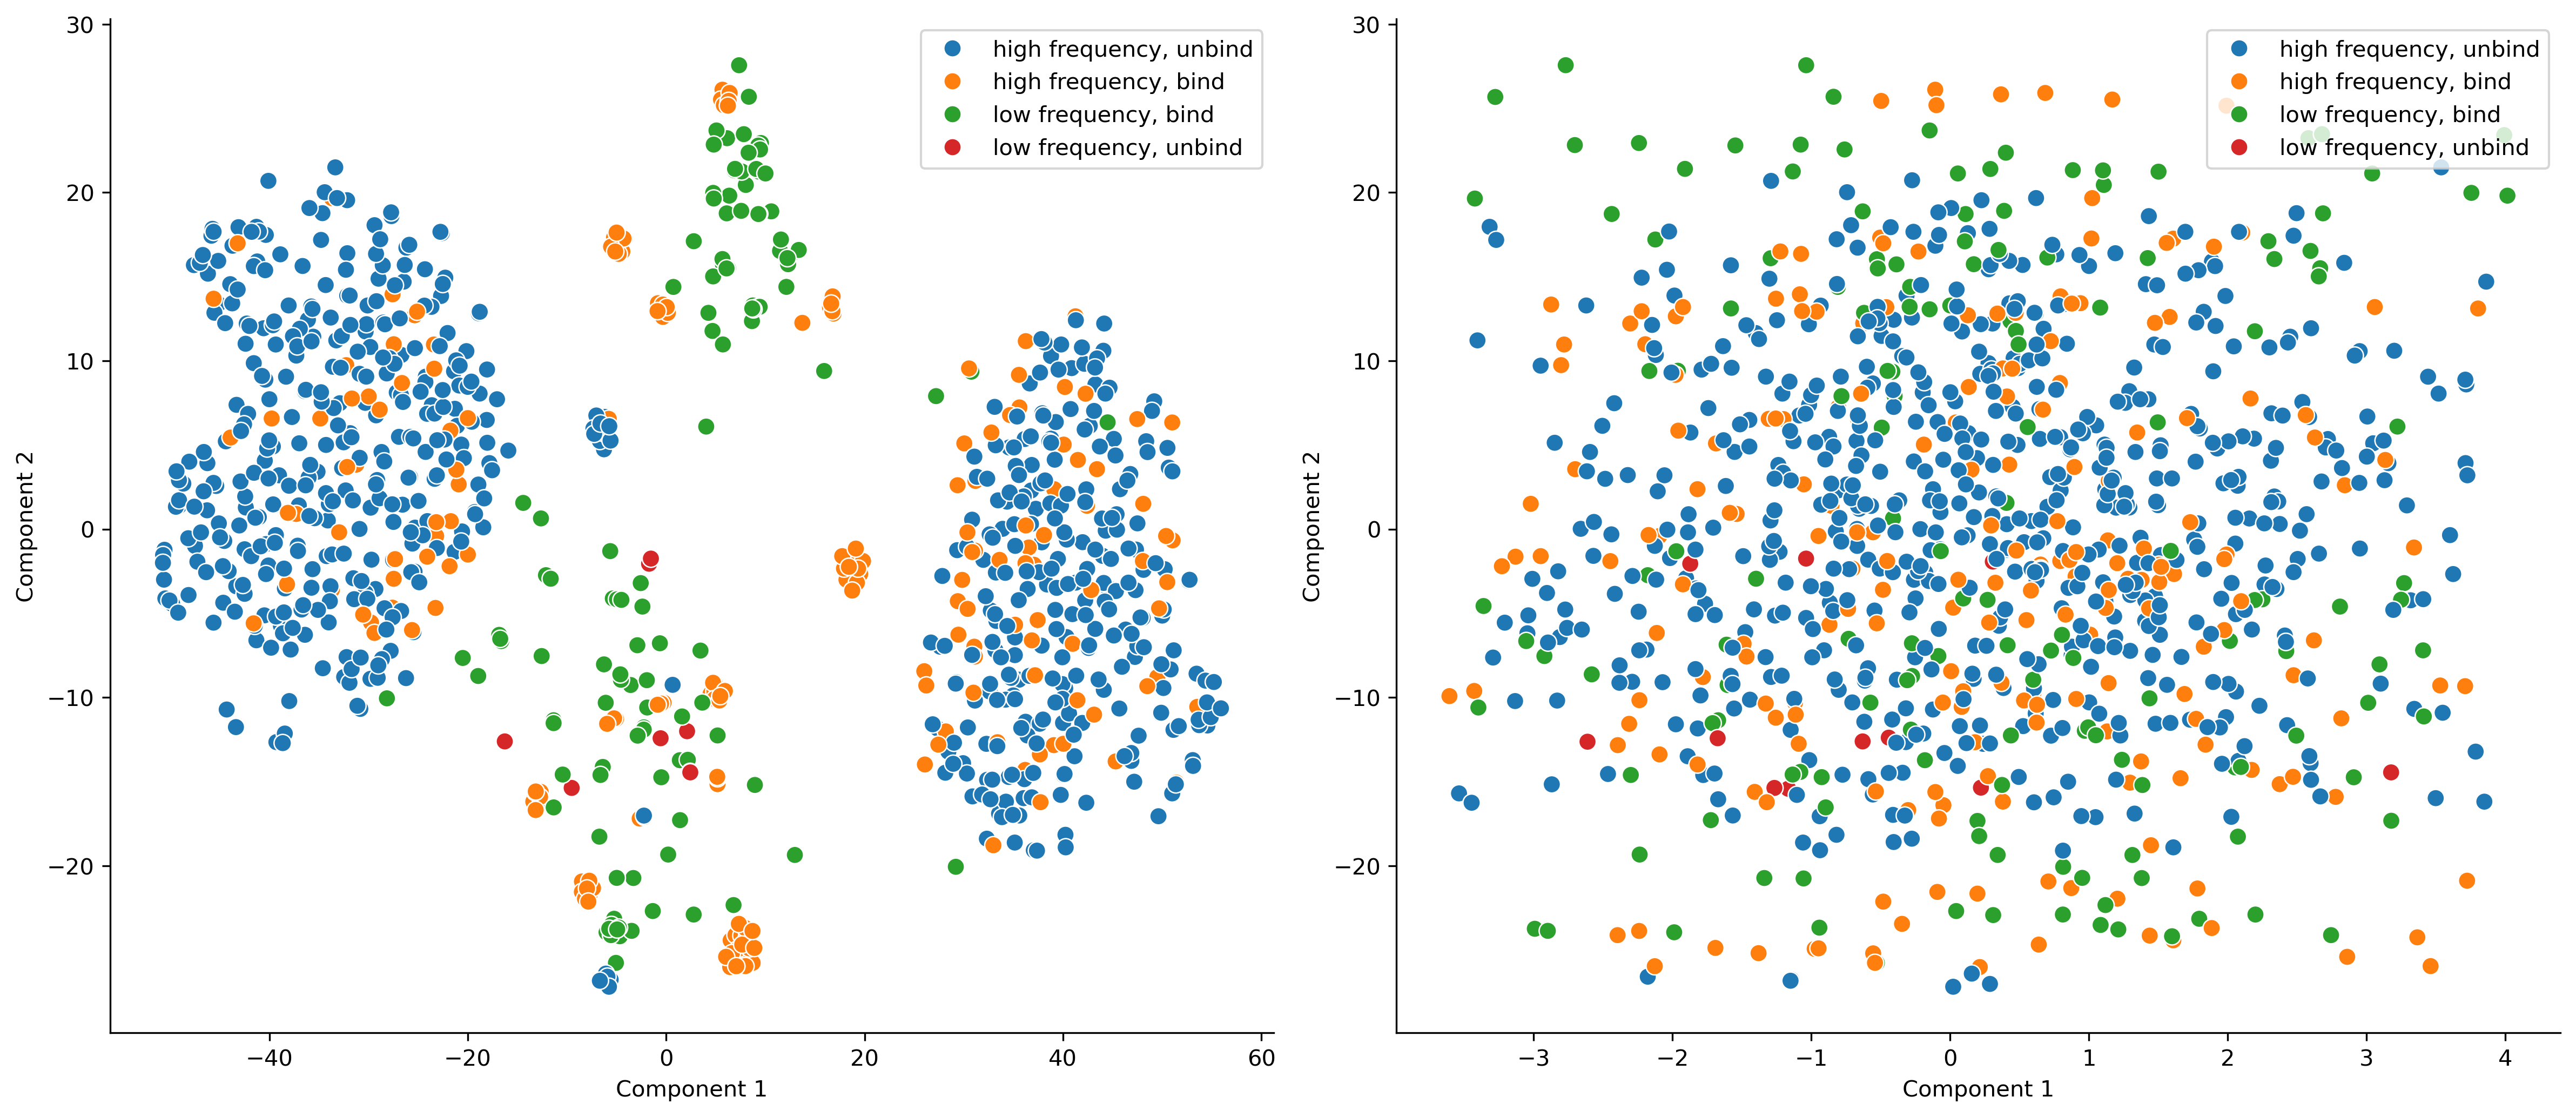

In [23]:
# Plotting
fig, axes = plt.subplots(1, 2, figsize=(16, 7), dpi = 300)

# t-SNE plot
sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=_hue, palette="tab10", ax=axes[0], s=60, legend = "full")
# axes[0].set_title(f'with pretrain h score: {with_pretrain_h_score}')
axes[0].set_xlabel('Component 1')
axes[0].set_ylabel('Component 2')
axes[0].spines['top'].set_visible(False)
axes[0].spines['right'].set_visible(False)

# # UMAP plot
sns.scatterplot(x=X_random_tsne[:, 0], y=X_tsne[:, 1], hue=_hue, palette="tab10", ax=axes[1], s=60, legend="full")
# axes[1].set_title(f'without pretrain h score: {without_pretrain_h_score}')
axes[1].set_xlabel('Component 1')
axes[1].set_ylabel('Component 2')
axes[1].spines['top'].set_visible(False)
axes[1].spines['right'].set_visible(False)

plt.tight_layout()
plt.show()